In [1]:
# Hannah
from google.colab import drive
import os
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
!pip install mplcursors
from sklearn.metrics import f1_score, precision_score, recall_score
#because jupyter notebook
%matplotlib inline

# Mount Google Drive to access your files
drive.mount('/content/drive') #, force_remount=True if need to remount

# !ls /content/drive/MyDrive/
# !ls /content/drive/MyDrive/Project-4/NormalBrainMRI_Images_files/Normal/
# !ls /content/drive/MyDrive/Project-4/Tumors/Tumor/

tumor_dir = '/content/drive/MyDrive/Project-4/Tumors/Tumor/'
normal_dir = '/content/drive/MyDrive/Project-4/NormalBrainMRI_Images_files/Normal/'

# Set up parameters for image loading
img_height = 224  # Adjust based on your needs
img_width = 224   # Adjust based on your needs
batch_size = 32   # Number of images to process in each batch

def create_dataset(directory, label, validation_split=0.2, subset='training'):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        labels=[label] * len(os.listdir(directory)),  # Manually specify labels
        label_mode='int',
        validation_split=validation_split,  # Use 20% of data for validation
        subset=subset,                      # This creates the training dataset
        seed=123,                           # Set a seed for reproducibility
        image_size=(img_height, img_width), # Resize all images to this size
        batch_size=batch_size,              # Number of images per batch
        shuffle=True                        # Shuffle the data: 1. Preventing order bias, 2.Improving generalization, 3. Reducing overfitting, 4. Balancing class distribution, 5. Stochastic gradient descent
                                            # Will provide further explanation in read me
        )

# Create datasets
tumor_train = create_dataset(tumor_dir, label=1, subset='training')
normal_train = create_dataset(normal_dir, label=0, subset='training')
tumor_val = create_dataset(tumor_dir, label=1, subset='validation')
normal_val = create_dataset(normal_dir, label=0, subset='validation')

'''
Why I chose tf.keras.utils.image_dataset_from_directory() instead of chose datagen.flow_from_directory():

Modern API: It's the more modern approach and is better integrated with TensorFlow 2.x's eager execution and @tf.function optimizations.
Performance: The tf.data API can potentially offer better performance, especially for large datasets, due to its ability to optimize the input pipeline.
Flexibility: It's easier to apply transformations and optimizations to the dataset using the tf.data API methods.
Simplicity: For your use case, where we're not doing complex data augmentation, this method provides a simpler, more straightforward approach.
Future-proofing: As TensorFlow continues to evolve, the tf.data API is likely to see more improvements and optimizations.
Consistent with modern TensorFlow practices: If you continue to work with TensorFlow, using this method aligns with current best practices and makes it easier to learn and apply more advanced techniques.
'''



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 173.3 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 33.4 MB/s eta 0:00:00
  Created wheel for mplcursors: filename=mplcursors-0.5.3-py3-none-any.whl size=20728 sha256=51e3bda1097dd74533e272a4b83f633d58ef934121041bb5a779dd9879391125
  Stored in directory: /root/.cache/pip/wheels/83/43/92/44f9515471f56877c774a515a2902d3e5484ea1bc7fd412d03
Successfully built mplcursors
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
Mounted at /content/drive


"\nWhy I chose tf.keras.utils.image_dataset_from_directory() instead of chose datagen.flow_from_directory():\n\nModern API: It's the more modern approach and is better integrated with TensorFlow 2.x's eager execution and @tf.function optimizations.\nPerformance: The tf.data API can potentially offer better performance, especially for large datasets, due to its ability to optimize the input pipeline.\nFlexibility: It's easier to apply transformations and optimizations to the dataset using the tf.data API methods.\nSimplicity: For your use case, where we're not doing complex data augmentation, this method provides a simpler, more straightforward approach.\nFuture-proofing: As TensorFlow continues to evolve, the tf.data API is likely to see more improvements and optimizations.\nConsistent with modern TensorFlow practices: If you continue to work with TensorFlow, using this method aligns with current best practices and makes it easier to learn and apply more advanced techniques.\n"

# Create validation datasets
try:
    tumor_val = create_dataset(tumor_dir, label=1, subset='validation')
    normal_val = create_dataset(normal_dir, label=0, subset='validation')
except FileNotFoundError as e:
    print(f"Error: {e}. Check if the directory paths are correct.")
    raise

In [5]:
# Combine datasets
train_ds = tumor_train.concatenate(normal_train)
val_ds = tumor_val.concatenate(normal_val)

In [6]:
# Optimize the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #This shuffle isn't redundant; it provides an extra layer of randomization.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Print information about the dataset
print("Number of training batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Number of validation batches:", tf.data.experimental.cardinality(val_ds).numpy())

for image_batch, labels_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

Image batch shape: (13, 224, 224, 3)
Labels batch shape: (13,)


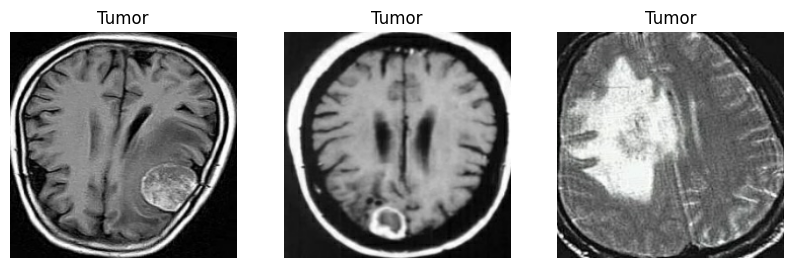

In [8]:
# Visualize some images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Tumor' if labels[i] == 1 else 'Normal')
        plt.axis("off")

plt.show()

In [9]:
# Agri

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the CNN model
def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        # First convolutional layer
        # 32 filters, 3x3 kernel size, ReLU activation
        # Input shape is (224, 224, 3) for RGB images
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        # Max pooling layer to reduce spatial dimensions
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer
        # 64 filters, 3x3 kernel size, ReLU activation
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Flatten the 2D feature maps for the fully connected layers
        layers.Flatten(),

        # Fully connected layer with 64 units and ReLU activation
        layers.Dense(64, activation='relu'),

        # Output layer with sigmoid activation for binary classification
        # Outputs a probability between 0 and 1
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [10]:
# Create and compile the model
model = create_cnn_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss='binary_crossentropy',  # Appropriate loss function for binary classification
    metrics=['accuracy']  # We want to track accuracy during training
)

In [11]:
# Train the model
hist = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=10  # Number of times to iterate over the entire dataset
)

# Visualize training history
plt.figure(figsize=(12, 4))

Epoch 1/10
9/9 [==============================] - 5s 474ms/step - loss: 1602.4254 - accuracy: 0.6537 - val_loss: 22.6240 - val_accuracy: 0.5714
Epoch 2/10
9/9 [==============================] - 3s 359ms/step - loss: 3.1518 - accuracy: 0.6732 - val_loss: 16.2811 - val_accuracy: 0.5714
Epoch 3/10
9/9 [==============================] - 3s 395ms/step - loss: 41.7634 - accuracy: 0.5097 - val_loss: 0.6931 - val_accuracy: 0.5714
Epoch 4/10
9/9 [==============================] - 3s 365ms/step - loss: 0.6931 - accuracy: 0.5759 - val_loss: 0.6930 - val_accuracy: 0.5714
Epoch 5/10
9/9 [==============================] - 3s 363ms/step - loss: 0.6930 - accuracy: 0.5759 - val_loss: 0.6929 - val_accuracy: 0.5714
Epoch 6/10
9/9 [==============================] - 3s 382ms/step - loss: 0.6929 - accuracy: 0.5759 - val_loss: 0.6929 - val_accuracy: 0.5714
Epoch 7/10
9/9 [==============================] - 3s 373ms/step - loss: 0.6929 - accuracy: 0.5759 - val_loss: 0.6928 - val_accuracy: 0.5714
Epoch 8/10
9/9

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

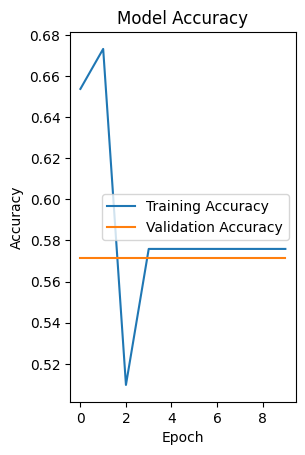

In [12]:
# Beatrik

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

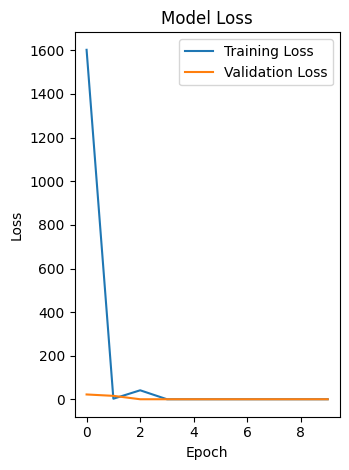

In [13]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation loss: {val_loss:.4f}")

3/3 [==============================] - 0s 45ms/step - loss: 0.6926 - accuracy: 0.5714
Validation accuracy: 0.5714


Since we only got 65% accuracy I will attempt Data Augmentation since its such a small dataset. This can increase our dataset size and help prevent overfitting.

I wwill use Transfer Learning; a VGG16 model since its trained on large datasets and can be fine-tuned for this task.

We will implement early stopping to prevent overfitting.

In [15]:
# TJ

from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import datetime
import io  # For handling in-memory streams, used for saving images
import itertools   #For consfusion matrix plotting
from sklearn.metrics import confusion_matrix

In [16]:
print(tf.__version__)
print(dir(tf.image))

# Data Augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_flip_up_down(image)
    # image = tf.image.random_rotation(image, 0.2)  <--- Couldnt use because colab only has tensorFlow version=2.15
    # image = tf.image.random_zoom(image, (0.9, 1.1))
    return image, label

# Apply augmentation to the training dataset
train_ds_augmented = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

2.15.0
['ResizeMethod', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'adjust_brightness', 'adjust_contrast', 'adjust_gamma', 'adjust_hue', 'adjust_jpeg_quality', 'adjust_saturation', 'central_crop', 'combined_non_max_suppression', 'convert_image_dtype', 'crop_and_resize', 'crop_to_bounding_box', 'decode_and_crop_jpeg', 'decode_bmp', 'decode_gif', 'decode_image', 'decode_jpeg', 'decode_png', 'draw_bounding_boxes', 'encode_jpeg', 'encode_png', 'extract_glimpse', 'extract_jpeg_shape', 'extract_patches', 'flip_left_right', 'flip_up_down', 'generate_bounding_box_proposals', 'grayscale_to_rgb', 'hsv_to_rgb', 'image_gradients', 'is_jpeg', 'non_max_suppression', 'non_max_suppression_overlaps', 'non_max_suppression_padded', 'non_max_suppression_with_scores', 'pad_to_bounding_box', 'per_image_standardization', 'psnr', 'random_brightness', 'random_contrast', 'random_crop', 'random_flip_left_right', 'random_flip_up_do

In [19]:
from sklearn.utils import class_weight
#Since our training data is imbalanced (ratio Tumor/Normal=1.32), I decided to add weights to prevent bias
y_train = np.concatenate([y for x, y in train_ds])

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.1788990825688073, 1: 0.8682432432432432}

In [22]:
# Model creation function
def create_model(fine_tune=False):
    # Load the pre-trained VGG16 model to use transfer learning
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze model base layers (New: added to unfreeze some layers for fine-tuning)
    if fine_tune:
        for layer in base_model.layers[-4:]:
            layer.trainable = True
    else:
        for layer in base_model.layers:
            layer.trainable = False

    # Create the final model, ressetting the model for each fold
    model = models.Sequential([
        # Add custom layers
        base_model,
        layers.GlobalAveragePooling2D(),      #L1/L2 regularization to prevent overfitting.
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', f1_score]
    )

    return model

In [21]:
from tensorflow.keras.callbacks import TensorBoard, Callback

# Set up the log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#Creates a writer for the log directory.
file_writer = tf.summary.create_file_writer(log_dir)

#Converts the matplotlib plot to a PNG TensorFlow image and returns it.
def plot_to_image(figure):
    #Save the plot to an in-memory buffer (like a file, but in memory)
    buf = io.BytesIO()  #temporarily store the image
    plt.savefig(buf, format='png')  #Save the plot as PNG image in the buffer
    plt.close(figure)  #Close to free up memory.
    buf.seek(0)  #Rewind the buffer to the beginning.

    #Decode the PNG image into a TensorFlow image and add a batch dimension (1).
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

#Define a function to log the confusion matrix as an image to TensorBoard.
def log_confusion_matrix(epoch, logs):
    val_labels = np.concatenate([y for x, y in val_ds], axis=0)
    class_names = ['Normal', 'Tumor']  # Adjust according to your specific problem

    # Get model predictions on the validation dataset.
    test_pred_raw = model.predict(val_ds)  # model.predict: Generate predictions for the validation dataset.

    # Convert predictions to binary values (0 or 1) based on a threshold of 0.5.
    test_pred = np.where(test_pred_raw > 0.5, 1, 0)  # np.where: Element-wise selection based on a condition.

    # Compute the confusion matrix using the true labels and predictions.
    cm = confusion_matrix(val_labels, test_pred)  # confusion_matrix: Generate the confusion matrix.

    # Plot the confusion matrix using Matplotlib.
    figure = plt.figure(figsize=(8, 8))  # plt.figure: Create a new figure.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # plt.imshow: Display the confusion matrix as an image.
    plt.title(f"Confusion Matrix at Epoch {epoch}")  # plt.title: Set the title of the plot.
    plt.colorbar()  # plt.colorbar: Add a color bar to the side of the plot.

    # Define the tick marks (class labels) on the x and y axes.
    tick_marks = np.arange(len(class_names))  # np.arange: Generate a range of numbers.
    plt.xticks(tick_marks, class_names, rotation=45)  # plt.xticks: Set the labels and rotation for the x-axis ticks.
    plt.yticks(tick_marks, class_names)  # plt.yticks: Set the labels for the y-axis ticks.

    # Normalize the confusion matrix so that each row sums to 1.
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # cm.sum(axis=1): Sum each row.

    # Annotate the matrix with text showing the normalized values.
    threshold = cm.max() / 2.  # Set a threshold to decide text color based on cell background.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):  # itertools.product: Cartesian product of the indices.
        color = "white" if cm[i, j] > threshold else "black"  # Choose white text if the cell is dark, black if light.
        plt.text(j, i, f"{cm[i, j]:.2f}", horizontalalignment="center", color=color)  # plt.text: Add text to the plot.

    # Set the labels for the axes.
    plt.ylabel('True label')  # plt.ylabel: Set the y-axis label.
    plt.xlabel('Predicted label')  # plt.xlabel: Set the x-axis label.

    # Convert the Matplotlib figure to a TensorFlow image.
    cm_image = plot_to_image(figure)

    # Write the confusion matrix image to TensorBoard.
    with file_writer.as_default():  # file_writer.as_default(): Set the file writer as the default context.
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)  # tf.summary.image: Write the image to TensorBoard.

# 5. Create a custom callback that logs the confusion matrix at the end of every epoch.
class ConfusionMatrixAndMetricsCallback(Callback):  # Callback: Base class for custom Keras callbacks.
        def __init__(self, val_ds, class_names):
          super().__init__()
          self.val_ds = val_ds
          self.class_names = class_names
          self.val_accuracies = []
          self.val_losses = []
          self.losses = []
          self.accuracies = []

        def on_epoch_end(self, epoch, logs=None):
          log_confusion_matrix(epoch, logs)

          # Track metrics
          logs = {}
          self.val_accuracies.append(logs.get('val_accuracy'))
          self.val_losses.append(logs.get('val_loss'))
          self.losses.append(logs.get('loss'))
          self.accuracies.append(logs.get('accuracy'))

          # Log the metrics to TensorBoard
          with file_writer.as_default():
              tf.summary.scalar('validation_accuracy', logs.get('val_accuracy'), step=epoch)
              tf.summary.scalar('validation_loss', logs.get('val_loss'), step=epoch)
              tf.summary.scalar('training_loss', logs.get('loss'), step=epoch)
              tf.summary.scalar('training_accuracy', logs.get('accuracy'), step=epoch)

confusion_matrix_and_metrics_callback = ConfusionMatrixAndMetricsCallback()  # Instantiate the custom callback.

In [33]:
#Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

confusion_matrix_and_metrics_callback = ConfusionMatrixAndMetricsCallback(val_ds, class_names)  # Instantiate the custom callback.

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-4
)

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Project-4/',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1,
                               mode='auto'
                               )

In [34]:
'''Had to do all of this because np.array() wouldnt take my batched data (a list or arrays)'''
# Convert train_ds to a list of batches
train_data = list(train_ds)

# Initialize empty lists to hold all images and labels
all_images = []
all_labels = []

# Iterate through each batch
for batch in train_data:
    images, labels = batch
    # Append the images and labels from each batch to the respective lists
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Convert the lists of batches into a single NumPy array
train_images = np.concatenate(all_images, axis=0)
train_labels = np.concatenate(all_labels, axis=0)

# Print to confirm shapes
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

Train images shape: (257, 224, 224, 3)
Train labels shape: (257,)


In [35]:
from sklearn.model_selection import KFold

k = 5  #Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=123)

#For storing cross-validation results
val_accuracies = []
val_losses = []
losses =[]
accuracies = []

# For storing best model
best_model = None

for fold, (train_indices, val_indices) in enumerate(kf.split(train_images)):
    print(f"Fold {fold+1}/{k}")

    #Create train and validation sets for this fold
    train_fold_images = train_images[train_indices]
    train_fold_labels = train_labels[train_indices]
    val_fold_images = train_images[val_indices]
    val_fold_labels = train_labels[val_indices]

    #Create TensorFlow datasets
    train_fold_ds = tf.data.Dataset.from_tensor_slices((train_fold_images, train_fold_labels)).batch(32)
    val_fold_ds = tf.data.Dataset.from_tensor_slices((val_fold_images, val_fold_labels)).batch(32)

    # Apply augmentation and optimization to the training set
    train_fold_ds_augmented = train_fold_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_fold_ds_augmented = train_fold_ds_augmented.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_fold_ds = val_fold_ds.cache().prefetch(buffer_size=AUTOTUNE)
    print(val_fold_ds)
    print(train_fold_ds_augmented)

    #Reset and compile the model for each fold
    model = create_model()
    model.metrics_names

    # Train the model on this fold's training set
    hist = model.fit(
        train_fold_ds_augmented,
        validation_data=val_fold_ds,
        epochs=100,
        callbacks=[lr_scheduler, early_stopping, checkpoint, confusion_matrix_and_metrics_callback, tensorboard_callback],
        class_weight=class_weights
    )
    # Evaluate the model
    val_accuracy = max(hist.history['val_accuracy'])
    val_loss = min(hist.history['val_loss'])

    #Store the results
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    '''Typically validation loss should be similar to but slightly higher than training loss.
    Keep training if validation loss is lower than or even equal to training loss.'''

Fold 1/5
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 6.2436 - accuracy: 0.5220
Epoch 1: val_accuracy improved from -inf to 0.71154, saving model to best_model.keras
7/7 [==============================] - 9s 1s/step - loss: 6.2436 - accuracy: 0.5220 - val_loss: 4.2983 - val_accuracy: 0.7115 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 5.4150 - accuracy: 0.5463
Epoch 2: val_accuracy did not improve from 0.71154
7/7 [==============================] - 7s 1s/step - loss: 5.4150 - accuracy: 0.5463 - val_loss: 4.0837 - val_accuracy: 0.6923 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 5.134

In [36]:
#Print cross-validation results
print(f"Average validation accuracy: {np.mean(val_accuracies):.4f} (+/- {np.std(val_accuracies):.4f})")
print(f"Average validation loss: {np.mean(val_losses):.4f} (+/- {np.std(val_losses):.4f})")

Average validation accuracy: 0.9453 (+/- 0.0420)
Average validation loss: 2.2289 (+/- 0.1499)


In [9]:
from tensorflow.keras.models import load_model
filepath = '/content/drive/MyDrive/Project-4/'

# Load the best model from the file
best_model = load_model(filepath)
fine_tuned_model = create_model(fine_tune=True)
fine_tuned_model.set_weights(best_model.get_weights())

OSError: No file or directory found at model.h5

In [6]:
print("Fine-tuning the model...")

# Use val_ds instead of val_fold_ds for fine-tuning
hist_fine_tune = fine_tuned_model.fit(
    train_ds_augmented,
    validation_data=val_ds,  # Use the original validation dataset
    epochs=100,
    callbacks=[lr_scheduler, early_stopping, checkpoint, confusion_matrix_and_metrics_callback, tensorboard_callback],
    class_weight=class_weights
)

# Save the fine-tuned model
fine_tuned_model.save("fine_tuned_model.keras")

Fine-tuning the model...


OSError: No file or directory found at best_model.keras

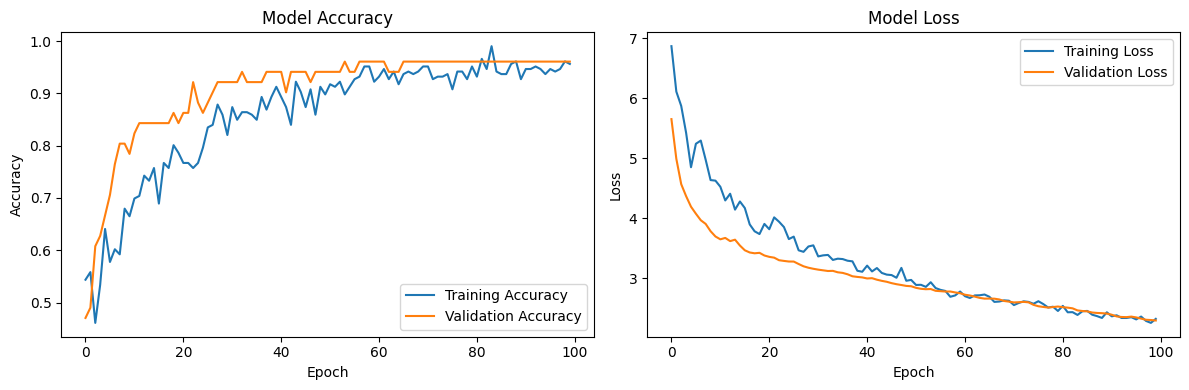

'\nOverfitting: If the training loss continues to decrease while the validation loss starts to increase, the model is overfitting.\nUnderfitting: If both training and validation loss are high, or if the accuracy is low, the model might be underfitting.\nGood Fit: If both training and validation losses decrease and eventually stabilize, with the validation accuracy close to the training accuracy, the model is likely performing well.\n'

In [38]:
# Paris

import matplotlib.pyplot as plt
import mplcursors

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # Add hover annotations
    cursor = mplcursors.cursor(hover=True)

    @cursor.connect("add")
    def on_add(sel):
        x, y = sel.target
        sel.annotation.set(text=f"{sel.artist.get_label()}: {y:.4f}\nEpoch: {int(x)}")

    plt.show()

# Plot training & validation accuracy before fine tuning.
plot_training_history(hist)

'''
Overfitting: If the training loss continues to decrease while the validation loss starts to increase, the model is overfitting.
Underfitting: If both training and validation loss are high, or if the accuracy is low, the model might be underfitting.
Good Fit: If both training and validation losses decrease and eventually stabilize, with the validation accuracy close to the training accuracy, the model is likely performing well.
'''

In [39]:
#Added final evaluation
final_val_loss, final_val_accuracy = fine_tuned_model.evaluate(val_ds)
print(f"Final validation accuracy: {final_val_accuracy:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")

3/3 [==============================] - 1s 304ms/step - loss: 1.3784 - accuracy: 0.4286
Final validation accuracy: 0.4286
Final validation loss: 1.3784


In [40]:
# Calculate and print the average validation accuracy and loss
mean_accuracy = np.mean(val_accuracies)
mean_loss = np.mean(val_losses)
print(f"Average validation accuracy across {k} folds: {mean_accuracy:.4f}")
print(f"Average validation loss across {k} folds: {mean_loss:.4f}")

Average validation accuracy across 5 folds: 0.9453
Average validation loss across 5 folds: 2.2289


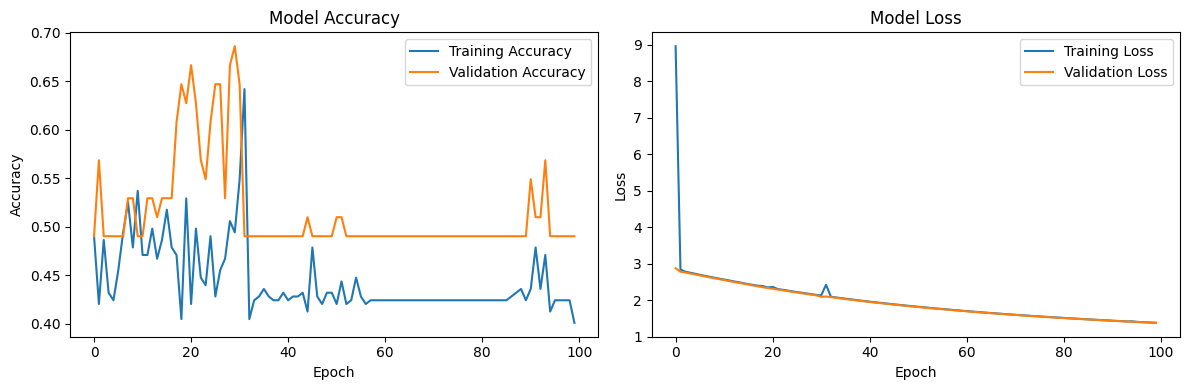

In [41]:
# Plot training & validation accuracy after fine tuning
model.evaluate()
plot_training_history(hist_fine_tune)

3/3 [==============================] - 1s 316ms/step
Sample of prediction probabilities: [[0.4906038 ]
 [0.49057057]
 [0.49048144]
 [0.4906038 ]
 [0.4906038 ]
 [0.49072   ]
 [0.49060777]
 [0.49064583]
 [0.4905386 ]
 [0.4906038 ]]


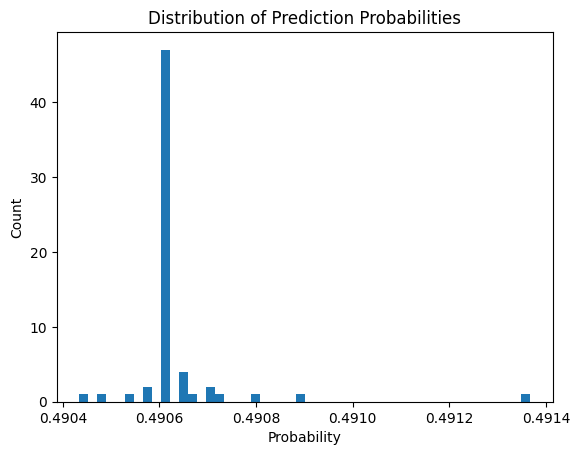

In [42]:
# Examine prediction probabilities
predictions = fine_tuned_model.predict(val_ds)
print("Sample of prediction probabilities:", predictions[:10])

# Plot prediction distribution
plt.hist(predictions, bins=50)
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

In [43]:
#Save the final model
fine_tuned_model.save("final_brain_tumor_model.keras")
print("Final model saved as 'final_brain_tumor_model.keras'")

Final model saved as 'final_brain_tumor_model.keras'


In [44]:
# To start TensorBoard in terminal:
# tensorboard --logdir=logs/fit

# To start TensorBoard in Jupyter notebook:
%load_ext tensorboard
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

In [ ]:
#Ran out of compute because apparently colab uses your compute even when not running :(
# from google.colab import runtime
# runtime.unassign()